In [1]:
# Step 1: Mount Google Drive and install dependencies
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine-Tuning Qwen and Saving

In [3]:
# Create directories for saving the fine-tuned model
import os
SAVE_DIR = "/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco"
os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
# Step 2: Initialize Unsloth and load the base Qwen model
from unsloth import FastLanguageModel
import torch

# Check CUDA availability
if torch.cuda.is_available():
    print("CUDA is available.")
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Device Count:", torch.cuda.device_count())
    print("Current Device ID:", torch.cuda.current_device())
else:
    print("CUDA is not available.")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
CUDA is available.
Device Name: Tesla T4
CUDA Device Count: 1
Current Device ID: 0


In [6]:
# Load the Qwen1.5-1.8B model with 4-bit quantization (optimized for training on T4 GPU)
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen1.5-1.8B-Chat",
    max_seq_length = 4096,     # Reduced context length to fit in T4 memory
    load_in_4bit = True,       # Use 4-bit quantization to save memory
    load_in_8bit = False,
    full_finetuning = False,   # We'll use LoRA instead
)

# Add LoRA adapters - only updating a small percentage of parameters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,                    # LoRA attention dimension
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                     "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,           # Alpha parameter for LoRA scaling
    lora_dropout = 0,          # Dropout probability for LoRA layers
    bias = "none",             # We don't adapt bias terms for efficiency
    use_gradient_checkpointing = "unsloth", # "unsloth" uses 30% less VRAM
    random_state = 3407,
)

print("Model loaded successfully!")

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Unsloth 2025.5.6 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


Model loaded successfully!


In [7]:
# Step 3: Create a tailored system prompt for Moroccan legal assistant
def create_moroccan_legal_system_prompt():
    """Create an effective system prompt for the Moroccan legal assistant"""

    system_prompt = """You are LegalAssistant, a professional legal advisor specializing in Moroccan law.

When answering questions:
- Base your answers strictly on the provided legal context from Moroccan law codes
- Cite specific articles mentioned in the context (by number and code name)
- If information is insufficient, clearly state "Based on the provided context, I don't have enough information to answer this question completely" rather than guessing
- Be concise and direct with your answers
- Use clear language that non-lawyers can understand
- Structure complex answers with numbered points when needed
- Maintain a formal, professional tone appropriate for legal advice
- Answer in the same language as the question (French or Arabic)

Your goal is to provide accurate Moroccan legal information without any hallucination or speculation."""

    return system_prompt

In [8]:
# Step 4: Load and prepare the Moroccan legal dataset
import json
import numpy as np
import pandas as pd
from datasets import Dataset
from tqdm.notebook import tqdm

# Load the Moroccan legal datasets
def load_moroccan_legal_dataset():
    """Load the Moroccan legal dataset from JSON files."""
    train_path = "/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/morocco/train_legal_data.json"
    eval_path = "/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/morocco/eval_legal_data.json"

    try:
        with open(train_path, 'r', encoding='utf-8') as f:
            train_data = json.load(f)

        with open(eval_path, 'r', encoding='utf-8') as f:
            eval_data = json.load(f)

        print(f"Loaded {len(train_data)} training examples")
        print(f"Loaded {len(eval_data)} evaluation examples")

        return {
            "train": train_data,
            "eval": eval_data
        }
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load dataset
moroccan_data = load_moroccan_legal_dataset()

Loaded 882 training examples
Loaded 151 evaluation examples


In [9]:
# Create conversation format for training
def create_legal_qa_conversations(examples, system_prompt=create_moroccan_legal_system_prompt()):
    """Convert the legal dataset into a conversation format for training"""
    conversations = []

    for example in tqdm(examples, desc="Processing examples"):
        # Create a conversation with system prompt
        conversations.append([
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Question: {example['question']}\n\nContexte juridique du Code Marocain:\n{example['context']}\n\nCode: {example['code']}\n\nVeuillez répondre en vous basant uniquement sur cette information."},
            {"role": "assistant", "content": f"{example['answer']}"},
        ])

    return {"conversations": conversations}

# Create training and validation datasets
train_data = create_legal_qa_conversations(moroccan_data["train"])
eval_data = create_legal_qa_conversations(moroccan_data["eval"])


Processing examples:   0%|          | 0/882 [00:00<?, ?it/s]

Processing examples:   0%|          | 0/151 [00:00<?, ?it/s]

In [10]:
# Apply chat template
train_conversations = tokenizer.apply_chat_template(
    train_data["conversations"],
    tokenize = False,
)

eval_conversations = tokenizer.apply_chat_template(
    eval_data["conversations"],
    tokenize = False,
)

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({"text": train_conversations})
eval_dataset = Dataset.from_dict({"text": eval_conversations})

print(f"Created training dataset with {len(train_dataset)} examples")
print(f"Created validation dataset with {len(eval_dataset)} examples")

Created training dataset with 882 examples
Created validation dataset with 151 examples


In [11]:
# Display a sample
print("\nSample conversation:")
print(train_conversations[0][:1000] + "...")


Sample conversation:
<|im_start|>system
You are LegalAssistant, a professional legal advisor specializing in Moroccan law.

When answering questions:
- Base your answers strictly on the provided legal context from Moroccan law codes
- Cite specific articles mentioned in the context (by number and code name)
- If information is insufficient, clearly state "Based on the provided context, I don't have enough information to answer this question completely" rather than guessing
- Be concise and direct with your answers
- Use clear language that non-lawyers can understand
- Structure complex answers with numbered points when needed
- Maintain a formal, professional tone appropriate for legal advice
- Answer in the same language as the question (French or Arabic)

Your goal is to provide accurate Moroccan legal information without any hallucination or speculation.<|im_end|>
<|im_start|>user
Question: Mon mari est décédé avant que nous ayons consommé le mariage. Ai-je quand même droit à l'int

In [12]:
# Step 5: Configure and run the training
from trl import SFTTrainer, SFTConfig

# Configure GPU memory stats tracking
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
1.914 GB of memory reserved.


In [13]:
# Configure the trainer with conservative settings for T4 GPU
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        max_seq_length = 4096,                # Reduced context length for T4 memory
        per_device_train_batch_size = 1,      # Conservative batch size for T4
        gradient_accumulation_steps = 16,     # Increased to simulate larger batch
        warmup_ratio = 0.05,                  # Slight increase for better stability
        num_train_epochs = 3,                 # Multiple epochs for better learning
        learning_rate = 1e-4,                 # Conservative learning rate
        logging_steps = 10,                   # Log metrics frequently
        save_steps = 50,                      # Save checkpoint frequently
        optim = "adamw_8bit",                 # 8-bit Adam optimizer to save memory
        weight_decay = 0.01,                  # L2 regularization
        lr_scheduler_type = "cosine",         # Cosine learning rate schedule
        eval_strategy = "steps",              # Evaluate during training
        eval_steps = 50,                      # Evaluate frequently
        save_total_limit = 3,                 # Keep only the 3 best checkpoints
        load_best_model_at_end = True,        # Load best model at the end
        seed = 42,
        report_to = "none",                   # Disable reporting to save resources
        output_dir = "checkpoints",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/882 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/151 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [14]:
# Run training
print("Starting training...")
trainer_stats = trainer.train()

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 882 | Num Epochs = 3 | Total steps = 165
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 14,991,360/8,000,000,000 (0.19% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,1.087300,1.181705
100,0.971500,1.087859
150,0.901000,1.068175


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss,Validation Loss
50,1.087300,1.181705
100,0.971500,1.087859
150,0.901000,1.068175


In [15]:
# Display final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1100.1117 seconds used for training.
18.34 minutes used for training.
Peak reserved memory = 3.793 GB.
Peak reserved memory for training = 1.879 GB.
Peak reserved memory % of max memory = 25.731 %.
Peak reserved memory for training % of max memory = 12.747 %.


In [26]:
# Step 6: Test the fine-tuned model with sample questions
def test_model_response(model, tokenizer, question, context, code):
    """Generate a response from the model for a legal question"""
    system_prompt = create_moroccan_legal_system_prompt()

    prompt = f"Question: {question}\n\nContexte juridique du Code Marocain:\n{context}\n\nCode: {code}\n\nVeuillez répondre en vous basant uniquement sur cette information."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    print("Generating response...")

    from transformers import TextStreamer
    inputs = tokenizer(text, return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.2,  # Added repetition penalty to reduce repetitive text
        streamer=TextStreamer(tokenizer, skip_prompt=True),
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Sample question from the evaluation set
sample_example = moroccan_data["eval"][0]

print("\n\n===== SAMPLE QUESTION =====")
print(sample_example["question"])
print("\n===== CONTEXT =====")
print(sample_example["context"])
print("\n===== CODE =====")
print(sample_example["code"])
print("\n===== MODEL RESPONSE =====")
test_model_response(model, tokenizer, sample_example["question"],
                   sample_example["context"], sample_example["code"])



===== SAMPLE QUESTION =====
Si je me marie religieusement (Fatiha) mais sans acte officiel, est-ce que mon mariage est reconnu si nous avons un enfant ensemble ?

===== CONTEXT =====
Article 16 [Code de la Famille]: Le document portant acte de mariage constitue le moyen de preuve
dudit mariage.
Lorsque des raisons impérieuses ont empêché l'établissement du
document de l'acte de mariage en temps opportun, le tribunal admet,
lors d'une action en reconnaissance de mariage, tous les moyens de
preuve ainsi que le recours à l'expertise.
Le tribunal prend en considération, lorsqu'il connaît d'une action en
reconnaissance de mariage, l'existence d'enfants ou de grossesse issus de
la relation conjugale et que l'action a été introduite du vivant des deux
époux.
L’action en reconnaissance de mariage est recevable pendant une
période transitoire maximum de quinze ans à compter de la date
d’entrée en vigueur de la présente loi3
.

===== CODE =====
code famille 2016

===== MODEL RESPONSE =====
Gen

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [24]:
# Step 7: Save the fine-tuned model for VLLM compatibility
# Create directory to save the model
model_dir = f"{SAVE_DIR}/qwen-morocco-legal"
os.makedirs(model_dir, exist_ok=True)

print("\n===== SAVING THE MODEL =====")
print("Saving model to Google Drive...")

# Step 1: Save LoRA adapters (lightweight)
model.save_pretrained(f"{model_dir}/lora")
tokenizer.save_pretrained(f"{model_dir}/lora")
print("LoRA adapters saved successfully!")

# Step 2: Save in float16 for VLLM (compatible with GTX 1650)
print("Converting to float16 format for VLLM compatibility...")
model.save_pretrained_merged(
    f"{model_dir}/merged_16bit",
    tokenizer,
    save_method="merged_16bit",
)
print("Float16 model for VLLM saved successfully!")

# Step 3: Save in 4bit format for more efficient inference
print("Converting to 4bit format for more efficient inference...")
model.save_pretrained_merged(
    f"{model_dir}/merged_4bit",
    tokenizer,
    save_method="merged_4bit_forced",  # Using _forced suffix for compatibility
)
print("4bit model saved successfully!")

print("\n===== MODEL SAVING COMPLETE =====")
print(f"All model versions saved to: {model_dir}/")



===== SAVING THE MODEL =====
Saving model to Google Drive...
LoRA adapters saved successfully!
Converting to float16 format for VLLM compatibility...


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 3.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.2 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 26.91it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving /content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/merged_16bit/pytorch_model.bin...
Done.
Float16 model for VLLM saved successfully!
Converting to 4bit format for more efficient inference...
Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Done.
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 10 minutes for Llama-7b... Done.
4bit model saved successfully!

===== MODEL SAVING COMPLETE =====
All model versions saved to: /content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/


# Qwen Evaluation

In [25]:
pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 MB 570.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 621.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 460.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=65dc3ea7cbcbfeb6e436938c03bb3fa0c739435756c0aef237b93906bfc130ab
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [1]:
import json
import time
import os
import numpy as np
import pandas as pd
import torch
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support

# Download nltk resources
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab')


# Create directory for saving results
RESULTS_DIR = "/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation2"
os.makedirs(RESULTS_DIR, exist_ok=True)

INFO 05-17 16:11:25 [__init__.py:239] Automatically detected platform cuda.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Function to create the Moroccan legal system prompt
def create_moroccan_legal_system_prompt():
    return """You are LegalAssistant, a professional legal advisor specializing in Moroccan law.

When answering questions:
- Base your answers strictly on the provided legal context from Moroccan law codes
- Cite specific articles mentioned in the context (by number and code name)
- If information is insufficient, clearly state "Based on the provided context, I don't have enough information to answer this question completely" rather than guessing
- Be concise and direct with your answers
- Use clear language that non-lawyers can understand
- Structure complex answers with numbered points when needed
- Maintain a formal, professional tone appropriate for legal advice
- Answer in the same language as the question (French or Arabic)

Your goal is to provide accurate Moroccan legal information without any hallucination or speculation."""

In [3]:
# Function to load the Moroccan legal dataset
def load_moroccan_dataset(eval_path="/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/moroccan_legal/eval_legal_data.json"):
    """Load the Moroccan legal evaluation dataset from JSON file."""
    try:
        with open(eval_path, 'r', encoding='utf-8') as f:
            eval_data = json.load(f)

        print(f"Loaded {len(eval_data)} evaluation examples")
        return eval_data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None


In [4]:
# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    """Calculate BLEU score for a candidate against a reference"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())

    # BLEU requires a list of references (each being a list of tokens)
    references = [reference_tokens]

    # Apply smoothing
    smoothie = SmoothingFunction().method1

    try:
        score = sentence_bleu(references, candidate_tokens, smoothing_function=smoothie)
        return score
    except Exception as e:
        print(f"Error calculating BLEU: {str(e)}")
        return 0.0


# Function to calculate word-based F1 score
def calculate_f1_score(reference, candidate):
    """Calculate F1 score based on word overlap"""
    reference_words = set(nltk.word_tokenize(reference.lower()))
    candidate_words = set(nltk.word_tokenize(candidate.lower()))

    # Calculate precision, recall, F1
    if len(candidate_words) == 0:
        precision = 0.0
    else:
        precision = len(reference_words.intersection(candidate_words)) / len(candidate_words)

    if len(reference_words) == 0:
        recall = 0.0
    else:
        recall = len(reference_words.intersection(candidate_words)) / len(reference_words)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


# Function to estimate faithfulness (how well it sticks to the context)
def estimate_faithfulness(response, context):
    """Estimate faithfulness of response to context"""
    # Simple heuristic: Check what percentage of sentences in the response
    # have significant overlap with content in the context
    response_sents = nltk.sent_tokenize(response.lower())
    context_sents = nltk.sent_tokenize(context.lower())

    # Convert to word sets for comparison
    context_words = set()
    for sent in context_sents:
        context_words.update(set(nltk.word_tokenize(sent)))

    supported_sents = 0
    for sent in response_sents:
        sent_words = set(nltk.word_tokenize(sent))
        overlap = len(sent_words.intersection(context_words))
        if overlap > 3:  # If at least 3 words overlap
            supported_sents += 1

    # Get faithfulness score
    if len(response_sents) > 0:
        faithfulness_score = supported_sents / len(response_sents)
    else:
        faithfulness_score = 0.0

    return faithfulness_score


# Check whether the response contains article citations
def contains_citations(response, context):
    """Check if the response contains article citations from the context"""
    # Look for common patterns of article citations in French/Arabic legal texts
    citation_patterns = [
        r"article \d+",
        r"art\. \d+",
        r"l'article \d+",
        r"articles? \d+[-,\s]",
        r"code [a-z]+"
    ]

    import re
    citation_count = 0
    for pattern in citation_patterns:
        matches = re.findall(pattern, response.lower())
        citation_count += len(matches)

    return {
        "has_citations": citation_count > 0,
        "citation_count": citation_count
    }

In [5]:
# Function to generate a response from the model
def generate_model_response(llm, tokenizer, question, context, code):
    """Generate a response using VLLM without streaming"""
    system_prompt = create_moroccan_legal_system_prompt()

    prompt = f"Question: {question}\n\nContexte juridique du Code Marocain:\n{context}\n\nCode: {code}\n\nVeuillez répondre en vous basant uniquement sur cette information.\n\n"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]

    # Apply chat template
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )

    # Set sampling parameters
    sampling_params = SamplingParams(
        temperature=0.5,
        top_p=0.9,
        top_k=50,
        max_tokens=512,
        repetition_penalty=1.2,
    )

    # Start timing
    start_time = time.time()

    # Generate without streaming
    outputs = llm.generate(text, sampling_params=sampling_params)
    response = outputs[0].outputs[0].text

    # Calculate timing
    total_time = time.time() - start_time

    # Calculate tokens
    response_tokens = len(tokenizer.encode(response))

    return response, total_time, response_tokens

In [6]:
# Function to calculate all metrics for a response
def calculate_metrics(reference, candidate, context):
    """Calculate all evaluation metrics"""
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # ROUGE scores
    rouge_scores = scorer.score(reference, candidate)

    # BLEU score
    bleu_score = calculate_bleu(reference, candidate)

    # Word F1 score
    word_f1 = calculate_f1_score(reference, candidate)

    # Faithfulness estimate
    faithfulness = estimate_faithfulness(candidate, context)

    # Check for citations
    citation_info = contains_citations(candidate, context)

    return {
        'rouge1_precision': rouge_scores['rouge1'].precision,
        'rouge1_recall': rouge_scores['rouge1'].recall,
        'rouge1_fmeasure': rouge_scores['rouge1'].fmeasure,
        'rouge2_precision': rouge_scores['rouge2'].precision,
        'rouge2_recall': rouge_scores['rouge2'].recall,
        'rouge2_fmeasure': rouge_scores['rouge2'].fmeasure,
        'rougeL_precision': rouge_scores['rougeL'].precision,
        'rougeL_recall': rouge_scores['rougeL'].recall,
        'rougeL_fmeasure': rouge_scores['rougeL'].fmeasure,
        'bleu': bleu_score,
        'word_f1_precision': word_f1['precision'],
        'word_f1_recall': word_f1['recall'],
        'word_f1': word_f1['f1'],
        'faithfulness': faithfulness,
        'has_citations': int(citation_info['has_citations']),
        'citation_count': citation_info['citation_count']
    }


In [7]:
# Function to classify response quality
def classify_response_quality(metrics):
    """Classify response quality based on metrics"""
    # Define threshold scores for different metrics
    thresholds = {
        'high': {
            'rougeL_fmeasure': 0.5,
            'faithfulness': 0.7,
            'word_f1': 0.4
        },
        'medium': {
            'rougeL_fmeasure': 0.3,
            'faithfulness': 0.5,
            'word_f1': 0.25
        }
    }

    # Determine quality level
    if (metrics['rougeL_fmeasure'] >= thresholds['high']['rougeL_fmeasure'] and
        metrics['faithfulness'] >= thresholds['high']['faithfulness'] and
        metrics['word_f1'] >= thresholds['high']['word_f1']):
        return "High"
    elif (metrics['rougeL_fmeasure'] >= thresholds['medium']['rougeL_fmeasure'] and
          metrics['faithfulness'] >= thresholds['medium']['faithfulness'] and
          metrics['word_f1'] >= thresholds['medium']['word_f1']):
        return "Medium"
    else:
        return "Low"

In [8]:
# Evaluate the model on the moroccan legal dataset
def evaluate_model(model_path, eval_data, num_samples=None, gpu_util=0.8):
    """Evaluate the model on Moroccan legal questions"""
    print(f"Loading model from {model_path}...")

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    print("Tokenizer loaded successfully")

    # Load the model with VLLM
    try:
        llm = LLM(
            model=model_path,
            tensor_parallel_size=1,
            gpu_memory_utilization=gpu_util,
            max_model_len=2048,  # Reduced for memory efficiency
            trust_remote_code=True,
        )
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model with {gpu_util} GPU util: {e}")
        print("Trying with lower GPU memory utilization...")
        llm = LLM(
            model=model_path,
            tensor_parallel_size=1,
            gpu_memory_utilization=0.6,
            max_model_len=1024,  # Further reduced
            trust_remote_code=True,
        )
        print("Model loaded with reduced parameters")

    # Sample dataset if requested
    if num_samples and num_samples < len(eval_data):
        np.random.seed(42)
        eval_samples = np.random.choice(eval_data, size=num_samples, replace=False).tolist()
    else:
        eval_samples = eval_data

    results = []

    # Process each example
    for i, example in enumerate(tqdm(eval_samples, desc="Evaluating examples")):
        question = example["question"]
        reference = example["answer"]
        context = example["context"]
        code = example.get("code", "")

        # Generate response
        try:
            response, generation_time, response_tokens = generate_model_response(
                llm, tokenizer, question, context, code
            )

            # Calculate metrics
            metrics = calculate_metrics(reference, response, context)

            # Determine quality class
            quality_class = classify_response_quality(metrics)

            # Store results
            results.append({
                "example_id": i,
                "question": question,
                "reference": reference,
                "response": response,
                "context": context,
                "code": code,
                "generation_time": generation_time,
                "response_tokens": response_tokens,
                "quality_class": quality_class,
                **metrics
            })

            # Print progress info
            if (i+1) % 5 == 0 or i == 0:
                print(f"\nExample {i+1}/{len(eval_samples)} ({quality_class} quality)")
                print(f"ROUGE-L F1: {metrics['rougeL_fmeasure']:.4f}, Faithfulness: {metrics['faithfulness']:.4f}")
                print(f"Time: {generation_time:.2f}s, Citations: {metrics['citation_count']}")

        except Exception as e:
            print(f"Error processing example {i}: {e}")

    # Calculate average scores
    results_df = pd.DataFrame(results)
    print("\nEvaluation complete!")

    return results_df


In [9]:

# Create visualizations of the results
def visualize_results(results_df):
    """Create and save visualizations of the evaluation results"""
    print("\nGenerating visualizations...")

    # Set style for all plots
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("viridis")

    # 1. Create a bar chart of key metrics
    plt.figure(figsize=(12, 8))
    metrics_to_plot = [
        'rouge1_fmeasure', 'rouge2_fmeasure', 'rougeL_fmeasure',
        'bleu', 'word_f1', 'faithfulness'
    ]

    mean_values = [results_df[metric].mean() for metric in metrics_to_plot]
    metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'Word F1', 'Faithfulness']

    bars = plt.bar(metric_names, mean_values, color=sns.color_palette("viridis", len(metrics_to_plot)))

    # Add values on top of bars
    for bar, value in zip(bars, mean_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.title('Average Performance Metrics for Moroccan Legal QA', fontsize=16)
    plt.ylim(0, max(mean_values) + 0.15)
    plt.ylabel('Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/key_metrics.png', dpi=300)

    # 2. Distribution of generation times
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['generation_time'], kde=True, bins=20, color='skyblue')

    plt.axvline(x=results_df['generation_time'].mean(), color='red', linestyle='--',
                label=f'Mean: {results_df["generation_time"].mean():.2f}s')

    plt.title('Response Generation Time Distribution', fontsize=15)
    plt.xlabel('Generation Time (seconds)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/generation_time.png', dpi=300)

    # 3. Response quality classification
    plt.figure(figsize=(10, 6))
    quality_counts = results_df['quality_class'].value_counts()
    total_samples = len(results_df)
    quality_percentages = quality_counts / total_samples * 100

    # Create pie chart
    plt.pie(quality_percentages, labels=['High', 'Medium', 'Low'],
            autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107', '#F44336'],
            explode=(0.05, 0, 0), shadow=True)

    plt.axis('equal')
    plt.title('Response Quality Distribution', fontsize=15)
    plt.savefig(f'{RESULTS_DIR}/quality_distribution.png', dpi=300)

    # 4. Scatter plot of ROUGE vs Faithfulness with color for quality classes
    plt.figure(figsize=(10, 8))

    # Define colors for different quality classes
    quality_colors = {
        'High': '#4CAF50',    # Green
        'Medium': '#FFC107',  # Yellow
        'Low': '#F44336'      # Red
    }

    for quality in ['High', 'Medium', 'Low']:
        subset = results_df[results_df['quality_class'] == quality]
        if not subset.empty:
            plt.scatter(subset['rougeL_fmeasure'], subset['faithfulness'],
                       s=80, alpha=0.7, label=quality, color=quality_colors[quality])

    plt.title('ROUGE-L vs Faithfulness by Response Quality', fontsize=15)
    plt.xlabel('ROUGE-L F1 Score', fontsize=12)
    plt.ylabel('Faithfulness Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Quality Class')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/rouge_vs_faithfulness.png', dpi=300)

    # 5. Citation analysis
    plt.figure(figsize=(12, 6))

    # Citation counts
    citation_data = [
        results_df['has_citations'].mean() * 100,  # Percentage with citations
        100 - results_df['has_citations'].mean() * 100  # Percentage without citations
    ]

    plt.pie(citation_data, labels=['With Citations', 'Without Citations'],
            autopct='%1.1f%%', startangle=90, colors=['#2196F3', '#E0E0E0'],
            explode=(0.05, 0), shadow=True)

    plt.axis('equal')
    plt.title('Responses With Article Citations', fontsize=15)
    plt.savefig(f'{RESULTS_DIR}/citation_analysis.png', dpi=300)

    # 6. Response length comparison with references
    plt.figure(figsize=(12, 6))

    # Add reference token counts if available, otherwise use estimates
    if 'reference_tokens' not in results_df.columns:
        results_df['reference_tokens'] = [len(r.split()) * 1.3 for r in results_df['reference']]

    plt.scatter(results_df['reference_tokens'], results_df['response_tokens'],
               alpha=0.6, s=70, color='purple')

    # Add regression line
    sns.regplot(x='reference_tokens', y='response_tokens', data=results_df,
                scatter=False, color='blue', line_kws={"linestyle": "--"})

    # Add line of equality
    max_tokens = max(results_df['reference_tokens'].max(), results_df['response_tokens'].max())
    plt.plot([0, max_tokens], [0, max_tokens], 'r-', alpha=0.7, label='Equal Length')

    plt.xlabel('Reference Length (tokens)', fontsize=12)
    plt.ylabel('Response Length (tokens)', fontsize=12)
    plt.title('Response vs Reference Length Comparison', fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/length_comparison.png', dpi=300)

    # 7. Language analysis (if applicable to Moroccan data)
    if 'language' in results_df.columns:
        plt.figure(figsize=(10, 6))
        language_counts = results_df['language'].value_counts()
        plt.bar(language_counts.index, language_counts.values, color=sns.color_palette("Set2"))
        plt.title('Response Language Distribution', fontsize=15)
        plt.xlabel('Language', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/language_distribution.png', dpi=300)

    print(f"Visualizations saved to {RESULTS_DIR}/")

    # Calculate and return summary statistics
    summary_stats = {
        'rouge1_f1': results_df['rouge1_fmeasure'].mean(),
        'rouge2_f1': results_df['rouge2_fmeasure'].mean(),
        'rougeL_f1': results_df['rougeL_fmeasure'].mean(),
        'bleu': results_df['bleu'].mean(),
        'word_f1': results_df['word_f1'].mean(),
        'faithfulness': results_df['faithfulness'].mean(),
        'citations_percentage': results_df['has_citations'].mean() * 100,
        'avg_citation_count': results_df['citation_count'].mean(),
        'avg_gen_time': results_df['generation_time'].mean(),
        'avg_tokens': results_df['response_tokens'].mean(),
        'high_quality_percentage': len(results_df[results_df['quality_class'] == 'High']) / len(results_df) * 100,
        'medium_quality_percentage': len(results_df[results_df['quality_class'] == 'Medium']) / len(results_df) * 100,
        'low_quality_percentage': len(results_df[results_df['quality_class'] == 'Low']) / len(results_df) * 100,
    }

    return summary_stats

In [10]:
# Function to show example responses
def show_examples(results_df, num_examples=2, metric='rougeL_fmeasure'):
    """Show best and worst examples based on a metric"""

    # Print summary stats first
    print(f"\n===== EVALUATION SUMMARY (n={len(results_df)}) =====")
    print(f"Average ROUGE-L: {results_df['rougeL_fmeasure'].mean():.4f}")
    print(f"Average Word F1: {results_df['word_f1'].mean():.4f}")
    print(f"Average Faithfulness: {results_df['faithfulness'].mean():.4f}")
    print(f"Average BLEU: {results_df['bleu'].mean():.4f}")
    print(f"Responses with citations: {results_df['has_citations'].mean()*100:.1f}%")
    print(f"Average generation time: {results_df['generation_time'].mean():.2f} seconds")

    quality_counts = results_df['quality_class'].value_counts(normalize=True) * 100
    print("\nQuality Distribution:")
    for quality, percentage in quality_counts.items():
        print(f"  {quality}: {percentage:.1f}%")

    # Sort by the chosen metric
    sorted_df = results_df.sort_values(by=metric, ascending=False)

    print(f"\n===== BEST {num_examples} EXAMPLES BY {metric} =====")
    for i in range(min(num_examples, len(sorted_df))):
        row = sorted_df.iloc[i]
        print(f"\nQuestion: {row['question']}")
        print(f"\nContext: {row['context'][:150]}..." if len(row['context']) > 150 else f"\nContext: {row['context']}")
        print(f"\nReference: {row['reference']}")
        print(f"\nModel Response: {row['response']}")
        print(f"\nMetrics:")
        print(f"  - {metric}: {row[metric]:.4f}")
        print(f"  - Faithfulness: {row['faithfulness']:.4f}")
        print(f"  - Quality Class: {row['quality_class']}")
        print(f"  - Citations: {row['citation_count']}")
        print(f"  - Generation Time: {row['generation_time']:.2f} seconds")
        print("\n" + "=" * 80)

    print(f"\n===== WORST {num_examples} EXAMPLES BY {metric} =====")
    for i in range(min(num_examples, len(sorted_df))):
        row = sorted_df.iloc[-(i+1)]
        print(f"\nQuestion: {row['question']}")
        print(f"\nContext: {row['context'][:150]}..." if len(row['context']) > 150 else f"\nContext: {row['context']}")
        print(f"\nReference: {row['reference']}")
        print(f"\nModel Response: {row['response']}")
        print(f"\nMetrics:")
        print(f"  - {metric}: {row[metric]:.4f}")
        print(f"  - Faithfulness: {row['faithfulness']:.4f}")
        print(f"  - Quality Class: {row['quality_class']}")
        print(f"  - Citations: {row['citation_count']}")
        print(f"  - Generation Time: {row['generation_time']:.2f} seconds")
        print("\n" + "=" * 80)



Loaded 151 evaluation examples
Evaluating model on 50 examples...
Loading model from /content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/merged_16bit...
Tokenizer loaded successfully
INFO 05-17 16:12:01 [config.py:717] This model supports multiple tasks: {'classify', 'reward', 'generate', 'embed', 'score'}. Defaulting to 'generate'.
WARNING 05-17 16:12:01 [arg_utils.py:1658] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 05-17 16:12:01 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/merged_16bit', speculative_config=None, tokenizer='/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/merged_16bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_se

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 05-17 16:12:27 [loader.py:458] Loading weights took 22.73 seconds
INFO 05-17 16:12:27 [model_runner.py:1140] Model loading took 3.4654 GiB and 22.994750 seconds
INFO 05-17 16:12:29 [worker.py:287] Memory profiling takes 1.30 seconds
INFO 05-17 16:12:29 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.80) = 11.79GiB
INFO 05-17 16:12:29 [worker.py:287] model weights take 3.47GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 1.39GiB; the rest of the memory reserved for KV Cache is 6.91GiB.
INFO 05-17 16:12:30 [executor_base.py:112] # cuda blocks: 2357, # CPU blocks: 1365
INFO 05-17 16:12:30 [executor_base.py:117] Maximum concurrency for 2048 tokens per request: 18.41x
INFO 05-17 16:12:33 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 05-17 16:13:07 [model_runner.py:1592] Graph capturing finished in 34 secs, took 0.16 GiB
INFO 05-17 16:13:07 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 39.35 seconds
Model loaded successfully


Evaluating examples:   0%|          | 0/50 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 1/50 (Low quality)
ROUGE-L F1: 0.2553, Faithfulness: 0.5000
Time: 1.37s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 5/50 (Medium quality)
ROUGE-L F1: 0.3093, Faithfulness: 1.0000
Time: 1.37s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 10/50 (Low quality)
ROUGE-L F1: 0.1699, Faithfulness: 1.0000
Time: 1.93s, Citations: 3


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 15/50 (Low quality)
ROUGE-L F1: 0.1652, Faithfulness: 0.1667
Time: 3.02s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 20/50 (Medium quality)
ROUGE-L F1: 0.3276, Faithfulness: 1.0000
Time: 1.65s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 25/50 (Medium quality)
ROUGE-L F1: 0.3380, Faithfulness: 1.0000
Time: 1.49s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 30/50 (Low quality)
ROUGE-L F1: 0.2459, Faithfulness: 1.0000
Time: 1.58s, Citations: 4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 35/50 (Low quality)
ROUGE-L F1: 0.2560, Faithfulness: 0.5000
Time: 1.45s, Citations: 0


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 40/50 (High quality)
ROUGE-L F1: 0.9310, Faithfulness: 1.0000
Time: 0.90s, Citations: 3


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 45/50 (Low quality)
ROUGE-L F1: 0.2763, Faithfulness: 0.6667
Time: 2.24s, Citations: 7


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Example 50/50 (Low quality)
ROUGE-L F1: 0.2748, Faithfulness: 1.0000
Time: 1.62s, Citations: 3

Evaluation complete!
Raw results saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation2/model_evaluation_results.csv

Generating visualizations...
Visualizations saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation2/

===== EVALUATION SUMMARY (n=50) =====
Average ROUGE-L: 0.3325
Average Word F1: 0.4048
Average Faithfulness: 0.8563
Average BLEU: 0.1613
Responses with citations: 92.0%
Average generation time: 1.68 seconds

Quality Distribution:
  Low: 56.0%
  Medium: 34.0%
  High: 10.0%

===== BEST 3 EXAMPLES BY rougeL_fmeasure =====

Question: Si un juge se trompe et que sa décision me cause un préjudice financier, puis-je demander une réparation à l'État ?

Context: Article 122 [Constitution du Maroc 2011]: Les dommages causés par une erreur judiciaire ouvrent droit à une réparation à la charge de l'Etat.

Reference: Oui, l'article 122 

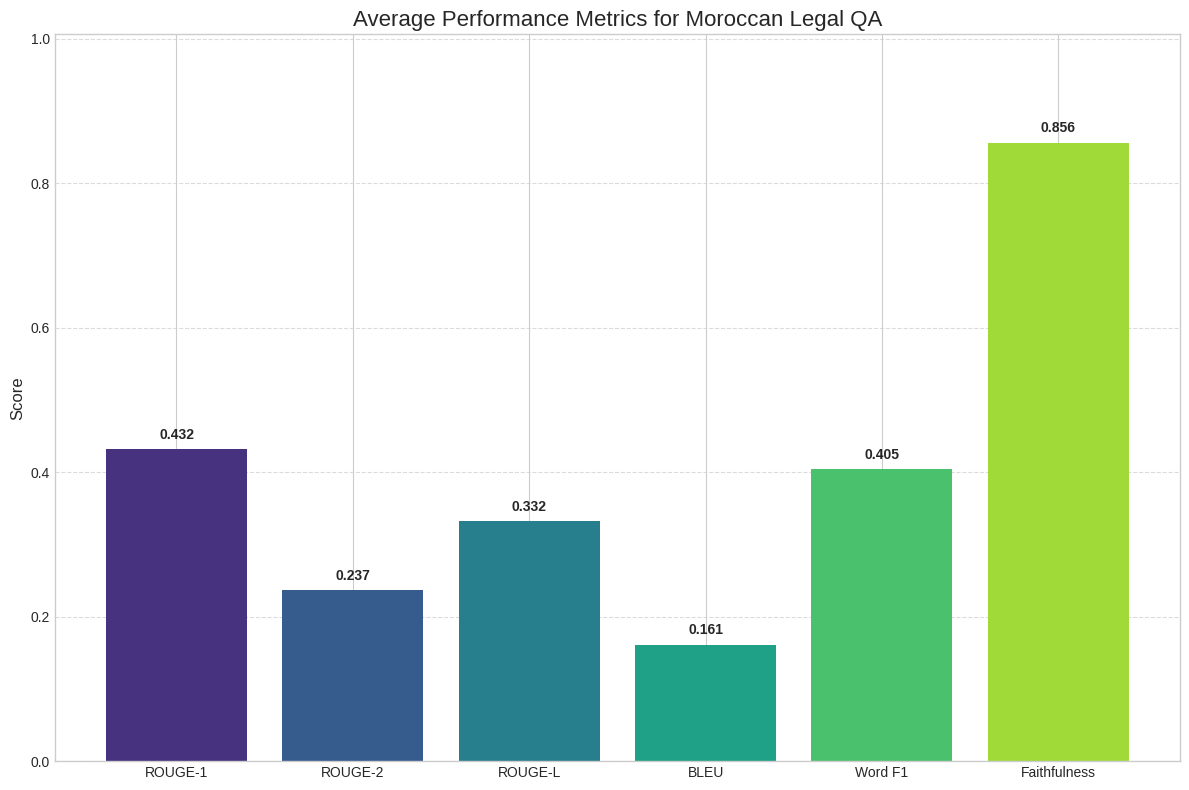

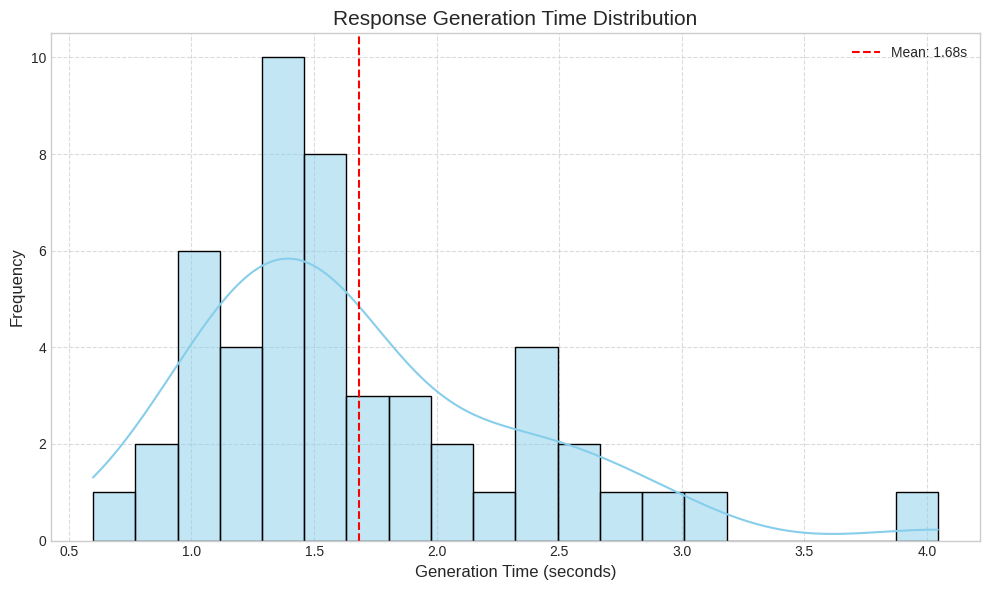

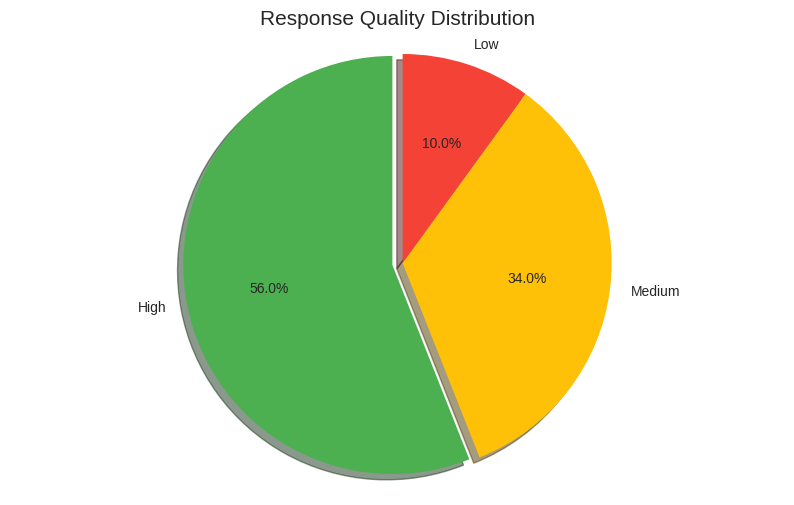

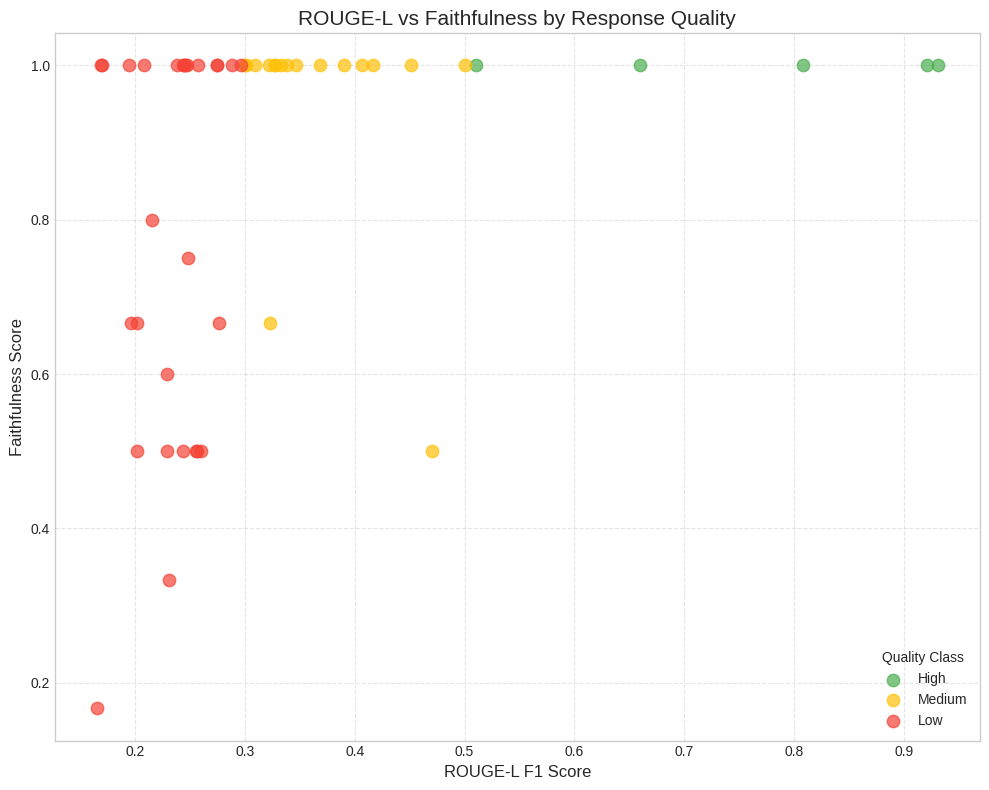

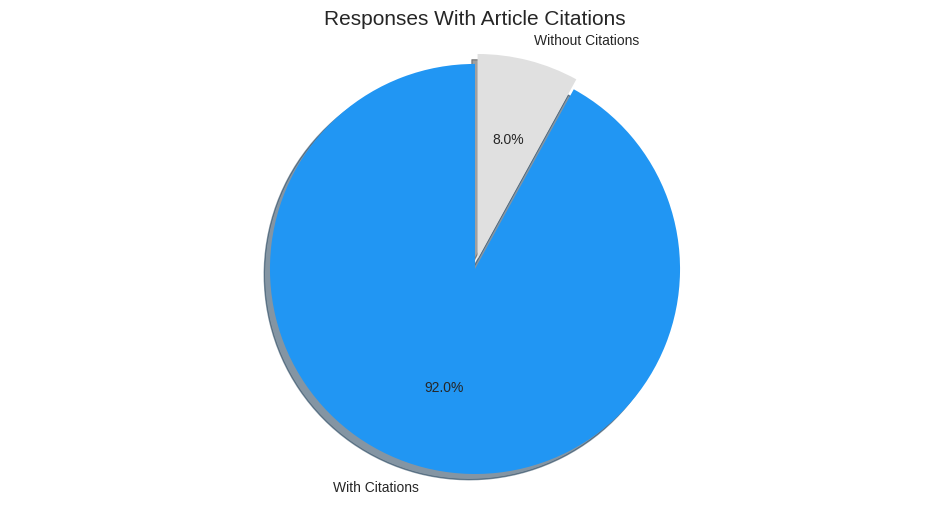

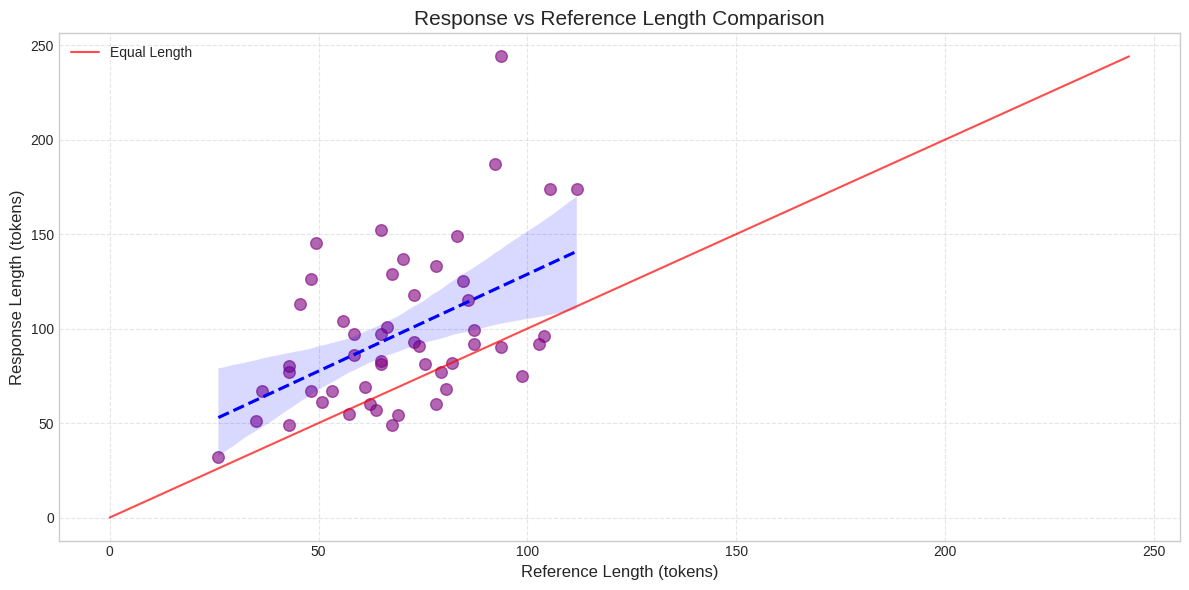

In [11]:
# Main execution function
def main():
    # Set parameters
    MODEL_PATH = "/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen-Morocco/qwen-morocco-legal/merged_16bit"  # Update with your model path
    EVAL_DATA_PATH = "/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/morocco/eval_legal_data.json" # Update with your data path
    NUM_EVAL_SAMPLES = 50  # Adjust based on your time constraints and dataset size

    # Load evaluation dataset
    eval_data = load_moroccan_dataset(EVAL_DATA_PATH)

    if eval_data:
        # Run evaluation
        print(f"Evaluating model on {NUM_EVAL_SAMPLES} examples...")
        results_df = evaluate_model(
            MODEL_PATH,
            eval_data,
            num_samples=NUM_EVAL_SAMPLES,
            gpu_util=0.8  # Adjust based on your GPU capabilities
        )

        # Save raw results to CSV
        results_file = f'{RESULTS_DIR}/model_evaluation_results.csv'
        results_df.to_csv(results_file, index=False)
        print(f"Raw results saved to {results_file}")

        # Create visualizations
        summary_stats = visualize_results(results_df)

        # Save summary stats to JSON
        with open(f'{RESULTS_DIR}/summary_stats.json', 'w') as f:
            json.dump(summary_stats, f, indent=2)

        # Show example responses
        show_examples(results_df, num_examples=3, metric='rougeL_fmeasure')

        print("\nEvaluation complete! All results saved to:", RESULTS_DIR)
    else:
        print("Evaluation aborted due to dataset loading error.")

if __name__ == "__main__":
    main()